<a href="https://colab.research.google.com/github/hugorichier/reco_images/blob/main/IALab_siamesenetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import tensorflow.keras.backend as K


target_shape = (200, 200)


In [ ]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [ ]:
!gdown --id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown --id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From: https://drive.google.com/uc?id=1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
To: /content/left.zip
104MB [00:02, 38.9MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
To: /content/right.zip
104MB [00:04, 22.6MB/s] 


In [ ]:

def preprocess_image(filename):
    """
    decode l'image en vecteurs et l'output en rgb
    changer le dtype de l'image de uint8 à float32
    resize 200*200
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    on fait passer les 3 types d'images par la fonction process
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [ ]:
# on place les images de /root/.keras/left dans anchor_images
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

# on place les images de /root/.keras/right dans postive_images
positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

#creation des dataset
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# Pour faire la liste d'image negative on randomise les images positives et ancres
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# on prend 80% du dataset pour l'entrainement et la validation
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

#32 images par batch s'il y en a moins dans le dernier on le garde
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

#La plupart des pipelines devrait avoir prefetch() à la fin pour preparer les elements suivant
#pendant que les elements actuels sont traités. Ca améliore la latence et le débit
#mais ca utilise plus de mémoire.


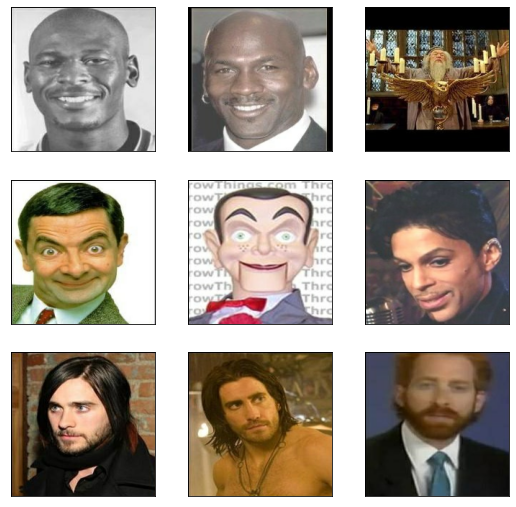

In [ ]:

def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
#nous allons récupérer une architecture de réseau convolutif pour notre base.
#les poids issus de l’entraînement sur ImageNet sont directement récupérés
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

#On rajoute des layers pour separer et classer les embedings.
flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")   

#fine-tuning
#Chaque layer possede un parametre "trainable".
#Pour freez le poids d'un layer, on met ce parametre en False pour indiquer qu'il
#ne doit pas être entrainé.
#En gros on choisis quel layers doivent être entrainés
trainable = False     
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:

class DistanceLayer(layers.Layer):
    """
    Dans ce layer on calcul la distance entre l'embeding de l'ancre et la positive
    et entre l'ancre et la négative
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

#distance est rajouté à la fin de notre model embedding
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),  
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

#on fait un nouveau model siamese_network qui englobe tout
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:

class SiameseModel(Model):
    """on fait un custom training loop.
    Quand on veut customiser l'algo d'apprentissage de son model on peut faire
    une class du model et implementer notre propre methode train_step()
    qui sera appelé dans Model.fit().
    On fait ca pour avoir un control bas niveau du training
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        #appelle le modele avec les nouveaux inputs
        return self.siamese_network(inputs)

    def train_step(self, data):
        
        #GradiantTape est utile pour 
        #mettre en oeuvre des algorithmes d'apprentissage automatique
        #ici on fait de la rétropropagation pour la formation du réseau.
        #On l'utilise pour calculer la perte et avoir son gradient et le 
        #réappliquer sur le reseau avec un optimizer

        with tf.GradientTape() as tape:
            #loss = ‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin
            loss = self._compute_loss(data)

        # On récuperer automatiquement les gradients de la fonction loss
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # On utilisent les gradients pour mettre à jour les poids du modele
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        #on met a jour loss et on retourn sa valeur.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        #test loop
        #Cette methode calcul la perte et met a jour ce parametre
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        #on recupere les distances calculer grace à DistanceLayer()
        ap_distance, an_distance = self.siamese_network(data)

        #on calcul notre nouvelle loss avec la fonction de triplet loss
        #loss = ‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        
        return [self.loss_tracker]


## Training


In [ ]:
siamese_model = SiameseModel(siamese_network)
#compile pour configurer le modele pour le training.
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
151/151 [==============================] - 118s 517ms/step - loss: 0.4928 - val_loss: 0.3777
Epoch 2/10
151/151 [==============================] - 76s 502ms/step - loss: 0.3865 - val_loss: 0.3634
Epoch 3/10
151/151 [==============================] - 76s 503ms/step - loss: 0.3765 - val_loss: 0.3690
Epoch 4/10
151/151 [==============================] - 76s 502ms/step - loss: 0.3560 - val_loss: 0.3534
Epoch 5/10
151/151 [==============================] - 76s 502ms/step - loss: 0.3483 - val_loss: 0.3463
Epoch 6/10
151/151 [==============================] - 76s 502ms/step - loss: 0.3349 - val_loss: 0.3161
Epoch 7/10
151/151 [==============================] - 76s 503ms/step - loss: 0.3227 - val_loss: 0.3224
Epoch 8/10
151/151 [==============================] - 76s 503ms/step - loss: 0.3107 - val_loss: 0.3172
Epoch 9/10
151/151 [==============================] - 76s 503ms/step - loss: 0.3041 - val_loss: 0.3103
Epoch 10/10
151/151 [==============================] - 76s 501ms/step - 

## Evaluation



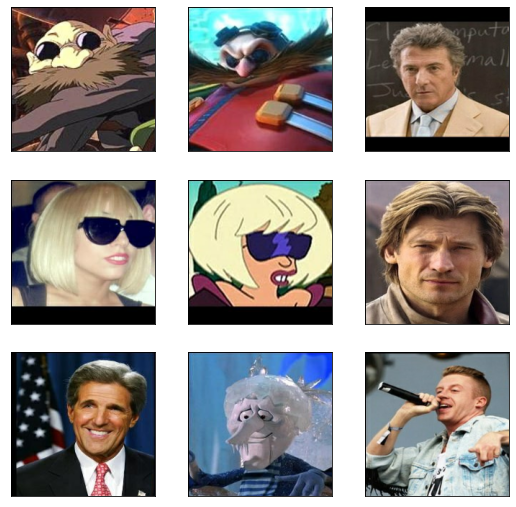

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

Finally, we can compute the cosine similarity between the anchor and positive
images and compare it with the similarity between the anchor and the negative
images.

We should expect the similarity between the anchor and positive images to be
larger than the similarity between the anchor and the negative images.

In [ ]:
cosine_similarity = metrics.CosineSimilarity()
#évalue la similarité entre deux vecteurs
#cos((A.B)/(|A|.|B|))
#print(cosine_similarity([1, 2, 3], [3, 2, 1]))

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.99451715
Negative similarity 0.9916817


In [ ]:
dist1, dist2 = siamese_network((resnet.preprocess_input(anchor), resnet.preprocess_input(positive), resnet.preprocess_input(negative)))

n_dist1 = np.linalg.norm(dist1)
n_dist2 = np.linalg.norm(dist2)
dist1 = dist1/n_dist1
dist2 = dist2/n_dist2

print(np.mean(dist1), "distance entre les images positives et ancres")
print(np.mean(dist2), "distance entre les images negatives et ancres")

0.113007225 distance entre les images positives et ancres
0.13788557 distance entre les images negatives et ancres


## Test avec les logos des associations de l'isep

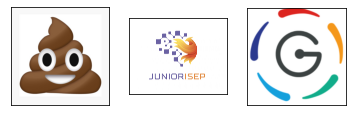

In [ ]:
from PIL import Image

anchor_image = Image.open("merde.jpeg")
positive_image = Image.open("junior.jpeg")
negative_image = Image.open("garage.jpeg")
f, axarr = plt.subplots(nrows=1,ncols=3)
axarr[0].imshow(anchor_image)
axarr[0].axes.get_xaxis().set_visible(False)
axarr[0].axes.get_yaxis().set_visible(False)
axarr[1].imshow(positive_image)
axarr[1].axes.get_xaxis().set_visible(False)
axarr[1].axes.get_yaxis().set_visible(False)
axarr[2].imshow(negative_image)
axarr[2].axes.get_xaxis().set_visible(False)
axarr[2].axes.get_yaxis().set_visible(False)

plt.show


anchor_image = tf.keras.preprocessing.image.img_to_array(anchor_image)
positive_image = tf.keras.preprocessing.image.img_to_array(positive_image)
negative_image = tf.keras.preprocessing.image.img_to_array(negative_image)

anchor_image = K.constant(anchor_image)
positive_image = K.constant(positive_image)
negative_image = K.constant(negative_image)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_image)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_image)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_image)

dataset = preprocess_triplets("merde.jpeg", "junior.jpeg", "garage.jpeg")

anchor, positive, negative = dataset
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor[None,:,:,:])),
    embedding(resnet.preprocess_input(positive[None,:,:,:])),
    embedding(resnet.preprocess_input(negative[None,:,:,:])),
)
#dataset = dataset.shuffle(buffer_size=1024)
#dataset = dataset.map(preprocess_triplets)

In [ ]:
dist1, dist2 = siamese_network((resnet.preprocess_input(anchor[None,:,:,:]), resnet.preprocess_input(positive[None,:,:,:]), resnet.preprocess_input(negative[None,:,:,:])))

n_dist1 = np.linalg.norm(dist1)
n_dist2 = np.linalg.norm(dist2)

print(n_dist1, "distance entre l'emoji merde et le logo junior isep")
print(n_dist2, "distance entre l'emoji merde et le logo garage isep")
print()
if n_dist1<n_dist2:
  print("le logo junior isep ressemble le plus à de la merde")
else:
  print("le logo garage isep ressemble le plus à de la merde")

0.0047462657 distance entre l'emoji merde et le logo junior isep
0.005900119 distance entre l'emoji merde et le logo garage isep

le logo junior isep ressemble le plus à de la merde
